Setting the enviroment, import dataset via keras

In [4]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import random
import timeit
from google.colab import drive
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler

Load data from keras, and scale the image

In [5]:
#number of classed in cifar100
n_classes = 100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# scaling the color of training and test data by dividing by 255 and convert into float 32 format
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

#convert the labels of image to categorical matrix structure, in order to make predictions
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

169017344/169001437 [==============================] - 3s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 100)
(10000, 100)


Use datagenerator to augment images

In [6]:
train_generator = ImageDataGenerator(
                                     rotation_range=15,
                                    horizontal_flip=True,
                                    width_shift_range = 0.1, 
                                    height_shift_range = 0.1,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False)



Built model

In [7]:
#according to this paper: https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
#0.0005 is good weight for cnn
weight_decay = 0.0005

model = Sequential()
# Build 13 hidden layer conv network of vgg inorder to dropout and weight decay as described in the paper
#block 1
#the inpt shape of cifar is 32 * 32 * 3
model.add(Conv2D(filters=64, kernel_size=[3, 3], input_shape=(32, 32, 3), strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
#Using batch normalization learning becomes efficient 
#also it can be used as regularization to avoid overfitting
model.add(BatchNormalization())
#Dropouts are the regularization technique that is used to prevent overfitting in the model 
model.add(Dropout(0.3)) 
model.add(Conv2D(filters=64, kernel_size=[3, 3], strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
# add max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

#block 2
model.add(Conv2D(filters=128, kernel_size=[3, 3], strides=1,activation='relu',padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(Dropout(0.4))
model.add(Conv2D(filters=128, kernel_size=[3, 3], strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2, 2)))

#block 3
model.add(Conv2D(filters=256, kernel_size=[3, 3], strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(Dropout(0.4))
model.add(Conv2D(filters=256, kernel_size=[3, 3], strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(Dropout(0.4))
model.add(Conv2D(filters=256, kernel_size=[3, 3], strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2, 2)))

#block 4
model.add(Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(Dropout(0.4))
model.add(Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu',padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(Dropout(0.4))
model.add(Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu',padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2, 2)))

#block 5
model.add(Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(Dropout(0.4))
model.add(Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(Dropout(0.4))
model.add(Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2, 2)))

#Add the Dense layers, activation and batch normalization
model.add(Flatten())
#rondomly drop neure to prevent overfitting
model.add(Dropout(rate=0.5))
#use relu as activation function to reducve vanishing gradient problem
model.add(Dense(units=512,activation = 'relu'))
#provides some regularization, reducing generalization error and accelerates the training
model.add(BatchNormalization())
model.add(Dense(units=100,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

Initializing the configuration of the generator

In [8]:
batch_size= 256
epochs=250
l_rate = 0.1
lr_drop = 20
#Adaptive learning rates, decrease as the epochs increase
def lr_scheduler(epoch):
    return l_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
#save the best model in drive it will ask you enter authorization code
drive.mount('/content/drive', force_remount=True)
checkpoint_best = 'vgg.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                            checkpoint_best,
                            save_weights_only=False,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True)
# simple early stopping, prevent over fitting
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 30)
#chooice SGD because it has better performance tha Adem
sgd = SGD(learning_rate= l_rate, decay=0.00000001, momentum=0.9,nesterov=True)
callbacks = [reduce_lr,model_checkpoint,es]
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

Mounted at /content/drive


In [9]:
start = timeit.default_timer()
history = model.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
                    epochs=epochs, 
                    batch_size=batch_size,
                    steps_per_epoch = x_train.shape[0] // batch_size,
                    #USE test as validation data to for real-time observation
                    validation_data=(x_test,y_test),
                    callbacks=callbacks, 
                    verbose=1)
stop = timeit.default_timer()
print('VGG Trainning Time: ', stop - start, 's') 

Epoch 1/250
195/195 [==============================] - 44s 134ms/step - loss: 10.4578 - accuracy: 0.0258 - val_loss: 10.7468 - val_accuracy: 0.0190
Epoch 2/250
195/195 [==============================] - 25s 128ms/step - loss: 8.4007 - accuracy: 0.0524 - val_loss: 8.0742 - val_accuracy: 0.0178
Epoch 3/250
195/195 [==============================] - 25s 128ms/step - loss: 6.8546 - accuracy: 0.0777 - val_loss: 6.9414 - val_accuracy: 0.0251
Epoch 4/250
195/195 [==============================] - 25s 128ms/step - loss: 5.8049 - accuracy: 0.1007 - val_loss: 6.2280 - val_accuracy: 0.0238
Epoch 5/250
195/195 [==============================] - 25s 128ms/step - loss: 5.0967 - accuracy: 0.1192 - val_loss: 5.3764 - val_accuracy: 0.0564
Epoch 6/250
195/195 [==============================] - 25s 129ms/step - loss: 4.5888 - accuracy: 0.1419 - val_loss: 4.9027 - val_accuracy: 0.0936
Epoch 7/250
195/195 [==============================] - 25s 129ms/step - loss: 4.2179 - accuracy: 0.1676 - val_loss: 4.8284

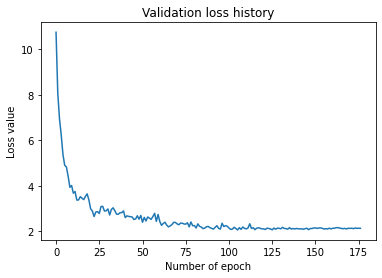

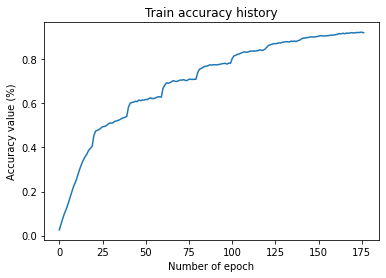

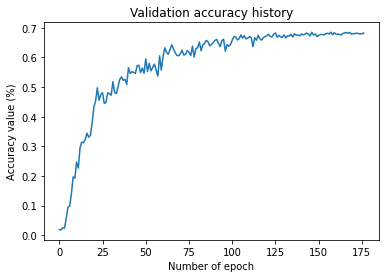

In [10]:
# Visualize of the model
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('Number of epoch')
plt.show()
# Plot history: Train Accuracy
plt.plot(history.history['accuracy'])
plt.title('Train accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('Number of epoch')
plt.show()
# Plot history: Validation Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('Number of epoch')
plt.show()


In [11]:
model = keras.models.load_model(checkpoint_best)

In [12]:
start = timeit.default_timer()
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob,axis=1)
y_truth = np.argmax(y_test,axis=1)
acc=np.sum(np.where(y_pred==y_truth,1,0))/y_truth.shape[0]
print('Test accuracy:', round(acc,4)*100, '%')
stop = timeit.default_timer()
print('VGG Predict time: ', stop - start, 's') 

Test accuracy: 68.49 %
VGG Predict time:  2.278915482999764 s


In [ ]:
model.save("group77_pretrained_model.h5")

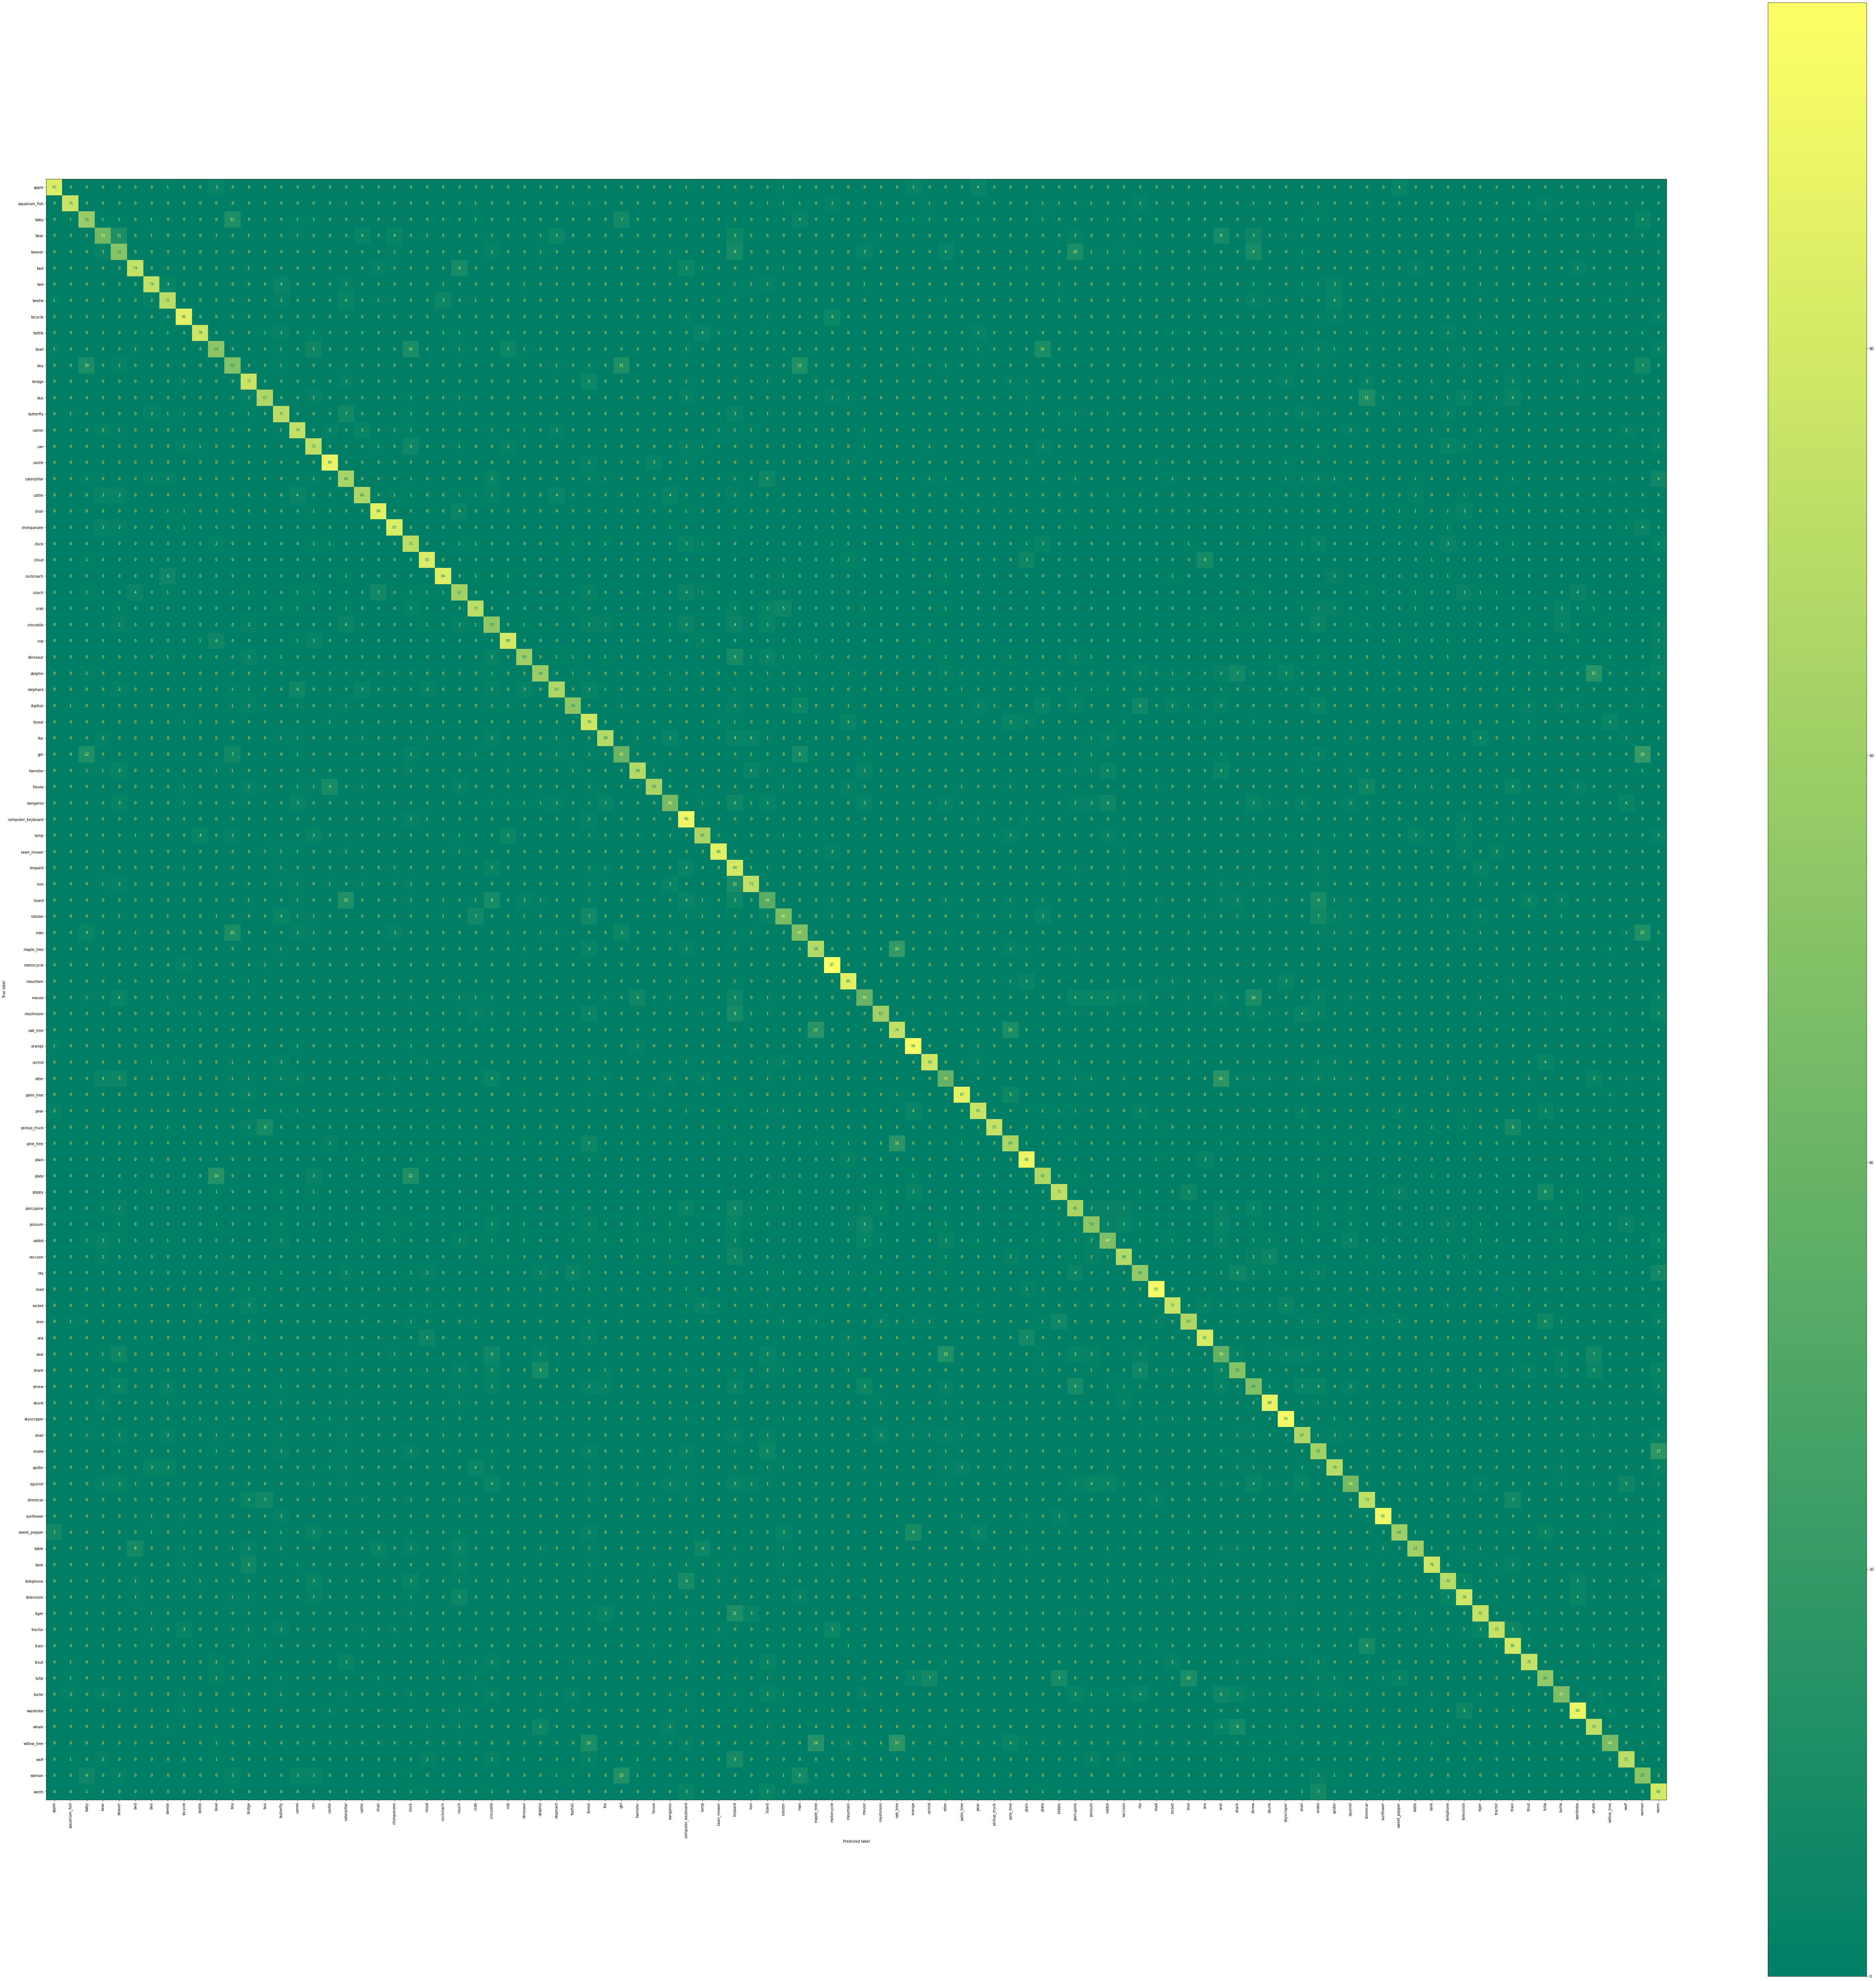

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# Define the labels of the dataset
labels = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle',
    'bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle',
    'chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur',
    'dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard',
    'lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain',
    'mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree',
    'plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose',
    'sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel',
    'streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train',
    'trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

cm = confusion_matrix(y_truth, y_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(100, 100))
disp = cm_disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [14]:
print(classification_report(y_truth, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       100
           1       0.89      0.76      0.82       100
           2       0.59      0.58      0.58       100
           3       0.55      0.43      0.48       100
           4       0.44      0.51      0.47       100
           5       0.80      0.74      0.77       100
           6       0.81      0.74      0.77       100
           7       0.70      0.71      0.70       100
           8       0.80      0.86      0.83       100
           9       0.88      0.78      0.83       100
          10       0.58      0.54      0.56       100
          11       0.55      0.50      0.52       100
          12       0.63      0.77      0.69       100
          13       0.76      0.67      0.71       100
          14       0.62      0.71      0.66       100
          15       0.67      0.74      0.70       100
          16       0.65      0.72      0.69       100
          17       0.82    